Each task that is proposed to be completed as part of the homework has a declared "price" in points. The maximum possible amount is 10 points, and together with the bonus assignment - 12 points. It is not necessary to complete all the tasks, only a part can be done. Most of the points expect you to write working Python code; sometimes you will need to write comments - for example, to compare several approaches to solve the same problem. Also you can add more cells for your convenience if you need.

This homework focuses on clustering. We will work with images of handwritten digits, learn how to cluster them using two different methods (hierarchical clustering and the 𝐾-means algorithm), evaluate the quality of the partition and choose the optimal number of clusters, as well as visualize intermediate results.

## 1. Loading data
The data we will be working with is available in the scikit-learn library (`sklearn` module) in the `datasets` submodule via the `load_digits` function. The data contains 1,797 observations, each of which is 8×8 pixel image of a handwritten digit from 0 to 9. This is about the same amount of each digit (about 180).

For convenience, every image expands to a 64 (8×8) row, so entire numpy array is 1797×64. The color intensity in each pixel is encoded with an integer from 0 to 16.

In addition to images, their labels are also known. In this task, we will assume that the labels (as well as their amount) are unknown and try to group the data in such a way that the resulting clusters 'better match' the original ones. Possible options for determining the 'better match' are presented later.

**(0.25 points)** Load the images into `X` variable, and their labels into `y` variable.

In [1]:
from sklearn.datasets import load_digits
import numpy as np
digits = load_digits()
print(digits.data.shape)

(1797, 64)


In [2]:
X,y = digits.data, digits.target

In [3]:
assert X.shape == (1797, 64)
assert y.shape == (1797,)

**(0.5 points)** Visualize the first 10 images.

- Arrange images on a grid rather than in a row. You may need the `subplot` and `imshow` functions from the `pyplot` module in the `matplotlib` library.
- You will also need to reshape the images to 8×8.
- Remove ticks and labels from both axes. The `xticks` and `yticks` functions or the `tick_params` function from `pyplot` can help you with this.
- Make the output good sized with the `figure` function from `pyplot`.

<function matplotlib.pyplot.show(close=None, block=None)>

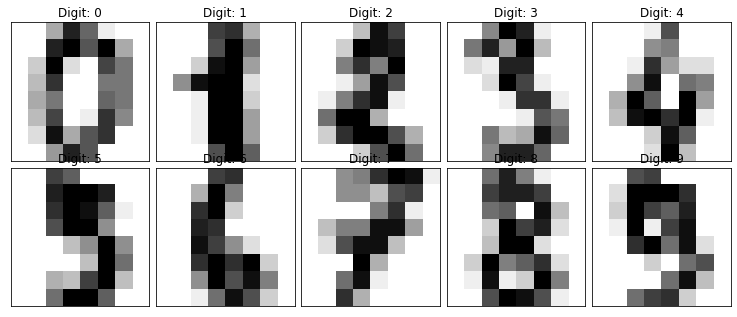

In [4]:
import matplotlib.pyplot as plt
#Figure size
fig = plt.figure(figsize=(10,10))
#Adjust the subplot
fig.subplots_adjust(left=0, right=1,bottom=0, top=1,hspace=0.05, wspace=0.05)
#For each ot the 64 images
for i in range(10):
    ax=fig.add_subplot(5,5,i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation ='nearest')
    ax.set_title(f'Digit: {i}')
    
#Show the plot
plt.show

## 2. Clustering and quality evaluation

**(2 points)** Implement the the KMeans algorithm. Use objective function $L = \sum_{i=1}^{n}|x_{i}-Z_{A(x_{i})}|^{2}$, where $Z_{A(x_{i})}$ is the center of the cluster corresponding to $x_{i}$ object.

In [5]:
from sklearn.exceptions import NotFittedError
from numpy.random import RandomState
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import KMeans

In [6]:
class CustomKMeans:
    def __init__(self, n_clusters=2, max_iter=30, n_init=10, random_state=42):
        '''K-Means clustering.

        Args:
            n_clusters: int, default=2
                The number of clusters to be formed is also 
                the number of centroids to generate. 
            max_iter: int, default=300
                Maximum number of iterations of the k-means algorithm for a
                single run.
            n_init: int, default=10
                Number of time the k-means algorithm will be run with different
                centroid seeds. The final results will be the best output of
                n_init consecutive runs in terms of objective function.
            random_state: int, default=42
                Random state.
        '''
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.random_state = RandomState(seed=random_state)
        self.histoty = []

    def calculate_distances_to_centroids(self, X, cluster_centers):
        """
        Returns (n, c) matrix where the element at position (i, j) 
        is the distance from i-th object to j-th centroid."""
        calculate_distances_to_centroids = pairwise_distances(X, cluster_centers, metric='euclidean', n_jobs=1)
        return calculate_distances_to_centroids

    def update_centroids(self, X, nearest_clusters):
        """
        Returns numpy array of shape (n_clusters, n_features) - 
        new clusters that are found by averaging objects belonging 
        to the corresponding cluster."""
        new_centroids = []
        for i in range(self.n_clusters):
            centroids = X[np.where(nearest_clusters == i)].mean(axis = 0)
            new_centroids.append(centroids)
        return np.array(new_centroids)

    def fit(self, X):
             
        """Fit the model.

        Args:
            X: numpy array of shape (n_samples, n_features)
        """
        assert X.shape[0] >= self.n_clusters
        # <your code>
        row, col = X.shape
        old_centroids = []   
        for j in range(self.n_clusters):
            RIndex = self.random_state.randint(row)
            old_centroids.append(X[RIndex]) 
    
        iteration = 0
        cluster_centers = old_centroids
        optimized = True
        distances_to_centroids_SUM = 0
        while optimized:
            old_cluster_centers = cluster_centers
            old_distances_to_centroids_SUM = distances_to_centroids_SUM
            distances_to_centroids = self.calculate_distances_to_centroids(X, old_cluster_centers)
            distances_to_centroids_SUM = np.sum(np.power(distances_to_centroids,2))
            classification = distances_to_centroids.argmin(axis = 1)
            cluster_centers = self.update_centroids(X, classification)
            self.histoty.append(old_distances_to_centroids_SUM - distances_to_centroids_SUM)
            if abs(old_distances_to_centroids_SUM - distances_to_centroids_SUM)<0.1:
                optimized = False
            iteration +=1
            if iteration == self.max_iter:
                optimized = False
        self.iteration = iteration
        self.cluster_centers_ = cluster_centers
        return classification

    def predict(self, X):
        """Predict classes.

        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted cluster labels.
        """
        if hasattr(self, 'cluster_centers_'):
            distances_to_centroids = self.calculate_distances_to_centroids(X, self.cluster_centers_)
            classification = distances_to_centroids.argmin(axis = 1)
            return classification
            # <your code>
        else:
            raise NotFittedError("CustomKMeans instance is not fitted yet")

**(1 points)** Get the `X` array partition into 10 clusters. Visualize the centers of clusters.
- We will assume that the center of the cluster is average value of all observations belonging to the cluster.
- The cluster centers should have the same shape as our observations (64). So you have to average the points across the rows.

In [7]:
C_KM = CustomKMeans(n_clusters=10,  max_iter=30, n_init=10)
C_KM.fit(X)

array([8, 0, 0, ..., 2, 4, 2])

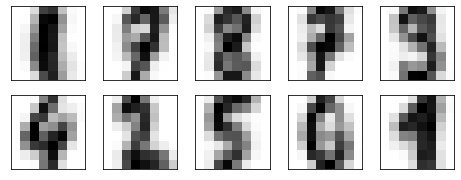

In [8]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = C_KM.cluster_centers_.reshape(10, 8, 8)

for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [9]:
custom_kmeans_labels = C_KM.predict(X)
assert custom_kmeans_labels.shape == (1797,)

**(0.5 points)** Experiment with `max_iter` and `n_init` parameters. Look at the range of values of the objective function, it's best values, at what parameters and how often they are achieved.

In [10]:
C_KM_2_1 = CustomKMeans(n_clusters=10,  max_iter=20, n_init=10)
# Меняем max_iter c 30 на 20 n_init с 10 на 30
C_KM_2_2 = CustomKMeans(n_clusters=10,  max_iter=20, n_init=30)
# Меняем max_iter c 30 на 40 n_init не трогаем
C_KM_2_3 = CustomKMeans(n_clusters=10,  max_iter=40, n_init=10)

In [11]:
# max_iter c 30 до 20 n_init с 10 на 20
C_KM_3_2 = CustomKMeans(n_clusters=10,  max_iter=20 , n_init=20)
# max_iter c 30 до 40 n_init с 10 на 20
C_KM_3_3 = CustomKMeans(n_clusters=10,  max_iter=50 , n_init=40)
# max_iter не трогаем  n_init с 10 на 30
C_KM_3_4 = CustomKMeans(n_clusters=10,  max_iter=30, n_init=30)

In [12]:
C_KM_3_4.fit(X)

array([8, 0, 0, ..., 2, 4, 2])

In [13]:

C_KM_3_3.fit(X)

array([8, 0, 0, ..., 2, 4, 2])

In [14]:
C_KM_2_1.fit(X)

array([8, 0, 0, ..., 2, 4, 2])

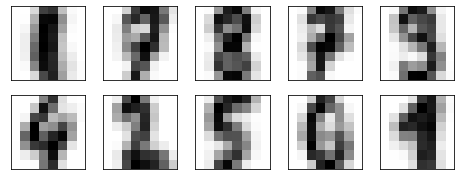

In [15]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = C_KM_2_1.cluster_centers_.reshape(10, 8, 8)

for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

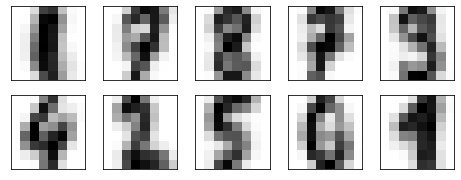

In [16]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = C_KM_3_3.cluster_centers_.reshape(10, 8, 8)

for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

Лично я не заметила особой разницы при изменении параметров, так как max_iter and n_init отвечают больше за обычное число итераций и их подходов, и не влияют на результаты модели. Больше смысла было бы при изменении параметра n_clusters.

Now we will use two popular algorithms: hierarchical clustering and $K$-means clustering. These and other algorithms are available in the `scikit-learn` module in the `cluster` submodule. Hierarchical clustering is called `AgglomerativeClustering`, and the $K$-means method is called `KMeans`.

**(0.5 points)** Use each of the two methods: hierarchical clustering and KMeans. Get the `X` array partition into 10 clusters.

- Note that `AgglomerativeClustering` does not have a `predict` method, so you can either use the `fit_predict` method or use the `fit` method and then look at the `labels_` attribute of the class instance.
- Kmeans performs multiple runs (default 10) with random centers and then returns the best partition in terms of average distance within the clusters. You can increase the number of runs to improve the quality of predictions in the `i_init` parameter.

In [17]:
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [18]:
#AgglomerativeClustering(Hierarchical clustering )
clustering = AgglomerativeClustering().fit(X)
clustering.fit_predict(X, y)

array([1, 0, 0, ..., 0, 0, 0])

In [19]:
clustering.labels_

array([1, 0, 0, ..., 0, 0, 0])

In [20]:
clustering.labels_.shape

(1797,)

In [21]:
#kmeans_labels
from sklearn.cluster import KMeans

In [22]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(X)

In [23]:
print(kmeans.labels_)

[5 7 7 ... 7 3 3]


In [24]:
kmeans.labels_.shape

(1797,)

In [25]:
hierarchical_labels = clustering.labels_
kmeans_labels = kmeans.labels_

In [26]:
assert hierarchical_labels.shape == (1797,)
assert kmeans_labels.shape == (1797,)

**(0.5 points)** Visualize the centers of clusters obtained by both methods.

In [27]:
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestCentroid

In [28]:
clf1 = NearestCentroid()
clf1.fit(X, kmeans_labels)
centers1=clf1.centroids_

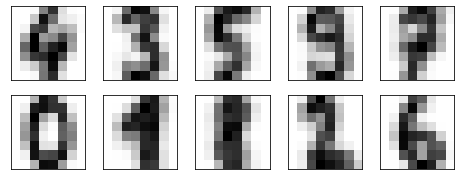

In [29]:
#Kmeans 
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers1 = kmeans.cluster_centers_.reshape(10, 8, 8)

for axi, center in zip(ax.flat, centers1):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [30]:
#hierarchical_labels 
clf2 = NearestCentroid()
clf2.fit(X, hierarchical_labels)
centers2=clf2.centroids_

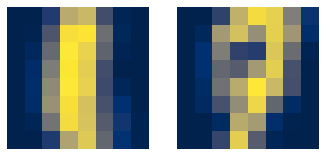

In [31]:
fig, ax = plt.subplots(figsize=(30, 30))
for i in range(len(centers2)):
    plt.subplot(1, 10, i + 1)
    image = centers[i]
    image = image.reshape(8,8)
    plt.imshow(image, cmap = 'cividis')
    plt.axis('off')
plt.show()

In a situation where the true number of classes is unknown, we can select it by maximazing some metric.

When we can set some distance function between our observations, we can consider the `silhouette` distance as a function of measuring the quality of the clustering. Let's show how it is calculated:

Let $X$ – set of observations, $M \subset X$ – one of the clusters obtained as a result of clustering process, $\rho$ – some metric on $X$. Let's choose one observation $x \in M$. Denote $a(x)$ as the average distance from $x$ to  $x'$ points from the same cluster:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Denote $b(x)$ as minimun of average distances from $x$ to $x''$ from some other cluster $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

The silhouette is difference between a(x) and b(x), normalized to $[-1, \, 1]$ and averaged over all observations:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

The implementation of this metric in the `scikit-learn` is the `silhouette_score` function from the `metrics` submidule.

**(0.75 point)** For each $K$ between 2 and 20 inclusive, partition of the array $X$ into $K$ clusters using both methods. Calculate the silhouette score and visualize it for both methods on the same plot ($K$ on the $x$ axis and silhouette score on the $y$ axis). Sign the axes and make a legend.

In [32]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [33]:
#the silhouette score calculate - AgglomerativeClustering
silhouette_avg = silhouette_score(X, hierarchical_labels)
print(f'Silhouette_avg on AgglomerativeClustering is {silhouette_avg}')
sample_silhouette_values = silhouette_samples(X, hierarchical_labels)
print(f'Sample_silhouette_values on AgglomerativeClustering are {sample_silhouette_values}')

Silhouette_avg on AgglomerativeClustering is 0.11674033985112256
Sample_silhouette_values on AgglomerativeClustering are [ 0.17822806  0.09277471  0.02078159 ... -0.0211315  -0.00861084
 -0.02105985]


In [34]:
score_ = []
N_1 = []
for n_clusters in range(2, 21):
    clusterer = KMeans(n_clusters=n_clusters).fit(X)
    preds = clusterer.predict(X)
    centers = clusterer.cluster_centers_

    score = silhouette_score (X, preds, metric='euclidean')
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
    score_.append(score)
    N_1.append(n_clusters)

For n_clusters = 2, silhouette score is 0.11832841100655983)
For n_clusters = 3, silhouette score is 0.12649498093440542)
For n_clusters = 4, silhouette score is 0.12274809783724604)
For n_clusters = 5, silhouette score is 0.13605384764819892)
For n_clusters = 6, silhouette score is 0.15159087166747598)
For n_clusters = 7, silhouette score is 0.16402593291003514)
For n_clusters = 8, silhouette score is 0.17840155523528725)
For n_clusters = 9, silhouette score is 0.18925821286715278)
For n_clusters = 10, silhouette score is 0.1824884181484339)
For n_clusters = 11, silhouette score is 0.1833430689445117)
For n_clusters = 12, silhouette score is 0.18457052554415576)
For n_clusters = 13, silhouette score is 0.18508878785802915)
For n_clusters = 14, silhouette score is 0.18576421993534437)
For n_clusters = 15, silhouette score is 0.18633462866695946)
For n_clusters = 16, silhouette score is 0.17373331646584103)
For n_clusters = 17, silhouette score is 0.17770905984048924)
For n_clusters = 1

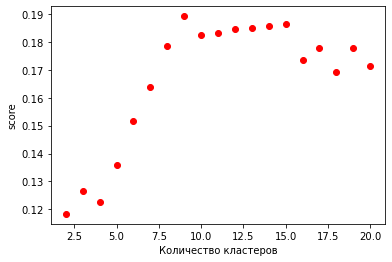

In [35]:
plt.xlabel('Количество кластеров')
plt.ylabel('score')
plt.scatter(x=N_1, c='r', y=score_)

In [36]:
#the silhouette score calculate - KMeans
silhouette_avg1 = silhouette_score(X, kmeans_labels)
print(f'Silhouette_avg on Kmeans is {silhouette_avg1}')
sample_silhouette_values1 = silhouette_samples(X, kmeans_labels)
print(f'Sample_silhouette_values on Kmeans are {sample_silhouette_values1}')

Silhouette_avg on Kmeans is 0.18251916424600556
Sample_silhouette_values on Kmeans are [ 0.42255296  0.18127659  0.14499037 ...  0.1622777   0.09092881
 -0.02908234]


In [37]:
score_ = []
N_2 = []
for n_clusters in range(2, 21):
    preds = AgglomerativeClustering(n_clusters=n_clusters).fit_predict(X)
    centers = clusterer.cluster_centers_

    score = silhouette_score (X, preds, metric='euclidean')
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
    score_.append(score)
    N_2.append(n_clusters)

For n_clusters = 2, silhouette score is 0.11674033985112256)
For n_clusters = 3, silhouette score is 0.11188954666963648)
For n_clusters = 4, silhouette score is 0.10895989445239453)
For n_clusters = 5, silhouette score is 0.11888125787404626)
For n_clusters = 6, silhouette score is 0.13701122727669246)
For n_clusters = 7, silhouette score is 0.15368571066948947)
For n_clusters = 8, silhouette score is 0.17056308645095428)
For n_clusters = 9, silhouette score is 0.18061975703867697)
For n_clusters = 10, silhouette score is 0.17849659940596496)
For n_clusters = 11, silhouette score is 0.17637337987696772)
For n_clusters = 12, silhouette score is 0.17362319379744087)
For n_clusters = 13, silhouette score is 0.1726407155529682)
For n_clusters = 14, silhouette score is 0.17670992249010575)
For n_clusters = 15, silhouette score is 0.17633457435967023)
For n_clusters = 16, silhouette score is 0.17695214651125427)
For n_clusters = 17, silhouette score is 0.17953047348045556)
For n_clusters = 

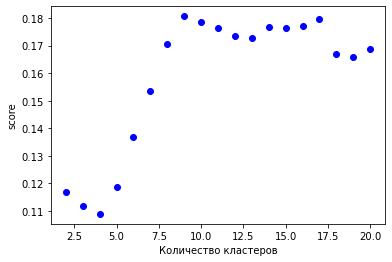

In [38]:
#visualize it
plt.xlabel('Количество кластеров')
plt.ylabel('score')
plt.scatter(x=N_2, c='b', y=score_)

When we know the true clustering labels, the clustering result can be compared to them using measures such as `homogeneity`, `completeness` and their harmonic mean - $V$-score. The definitions of these quantities are rather bulky and are based on the [entropy of the probability distribution](https://ru.wikipedia.org/wiki/Информационная_энтропия). Details are given in [this article](http://aclweb.org/anthology/D/D07/D07-1043.pdf). In practice, it's enough to know that `homogeneity`, `completeness` and $V$-score are in the range from 0 and 1, and the more, the better.

Since we know what digit each image is (`y` array), we can compare the clustering results to it using the measures listed above.

**(0.5 points)** Repeat the previous task using $V$-measure instead of silhouette.

In [39]:
#𝑉 -measure instead of silhouette
from sklearn.metrics import v_measure_score as VV

In [40]:
VV_ = []
N1 = []
for n_clusters in range(2, 21):
    clusterer = KMeans(n_clusters=n_clusters).fit(X)
    preds = clusterer.predict(X)
    centers = clusterer.cluster_centers_

    score = VV(preds, y)
    print ("For n_clusters = {}, VV score is {})".format(n_clusters, score))
    VV_.append(score)
    N1.append(n_clusters)

For n_clusters = 2, VV score is 0.36001205373704537)
For n_clusters = 3, VV score is 0.40401655029571565)
For n_clusters = 4, VV score is 0.45354248946493353)
For n_clusters = 5, VV score is 0.5830002606917807)
For n_clusters = 6, VV score is 0.5968427145921994)
For n_clusters = 7, VV score is 0.6501966190385284)
For n_clusters = 8, VV score is 0.7166185830750348)
For n_clusters = 9, VV score is 0.7180865213337131)
For n_clusters = 10, VV score is 0.7405741684855038)
For n_clusters = 11, VV score is 0.7741667889371413)
For n_clusters = 12, VV score is 0.7669760166606313)
For n_clusters = 13, VV score is 0.7726443602345454)
For n_clusters = 14, VV score is 0.7773587244544682)
For n_clusters = 15, VV score is 0.756045740228847)
For n_clusters = 16, VV score is 0.7831816379474585)
For n_clusters = 17, VV score is 0.7888806489356324)
For n_clusters = 18, VV score is 0.7737353667731948)
For n_clusters = 19, VV score is 0.7515039434004452)
For n_clusters = 20, VV score is 0.7700832943211088)

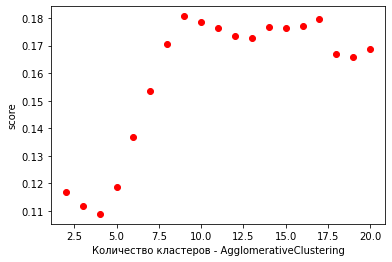

In [41]:
plt.xlabel('Количество кластеров - AgglomerativeClustering')
plt.ylabel('score')
plt.scatter(x=N1, c='r', y=score_)

In [42]:
VV_ = []
N2 = []
for n_clusters in range(2, 21):
    preds = AgglomerativeClustering(n_clusters=n_clusters).fit_predict(X)
    centers = clusterer.cluster_centers_

    score = VV(preds, y)
    print ("For n_clusters = {}, VV score is {})".format(n_clusters, score))
    VV_.append(score)
    N2.append(n_clusters)

For n_clusters = 2, VV score is 0.40824218623422054)
For n_clusters = 3, VV score is 0.5440613747462535)
For n_clusters = 4, VV score is 0.6211638409365546)
For n_clusters = 5, VV score is 0.709653527412938)
For n_clusters = 6, VV score is 0.7566664944734937)
For n_clusters = 7, VV score is 0.7983006479287973)
For n_clusters = 8, VV score is 0.8457771039270545)
For n_clusters = 9, VV score is 0.8446597933958961)
For n_clusters = 10, VV score is 0.8681701126909083)
For n_clusters = 11, VV score is 0.8553799643497675)
For n_clusters = 12, VV score is 0.86854875186737)
For n_clusters = 13, VV score is 0.8571580830709692)
For n_clusters = 14, VV score is 0.8517473904948195)
For n_clusters = 15, VV score is 0.8401879606185283)
For n_clusters = 16, VV score is 0.8321252325100416)
For n_clusters = 17, VV score is 0.8383091399615094)
For n_clusters = 18, VV score is 0.8271076710894292)
For n_clusters = 19, VV score is 0.826280611466587)
For n_clusters = 20, VV score is 0.8250943463532207)


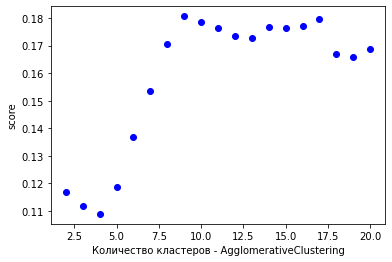

In [43]:
plt.xlabel('Количество кластеров - AgglomerativeClustering')
plt.ylabel('score')
plt.scatter(x=N2, c='b', y=score_)

## 3. Feature space dimensionality reduction

In some cases, especially when there are a large number of features, when not all of them are informative, and some of them are correlated, it can be useful to reduce the dimension of the feature space. This mean that instead of $d$ original features, we will go to $d'\ll d$ new ones. And if earlier our data were presented in the form of an $n×d$ matrix, then it will presented as a $n×d'$.

There are two popular dimensionality reduction approaches:
- select new features from existing features;
- extract the new features by transforming old ones, for example, by making $d'$ different linear combinations of columns of an $n×d$ matrix.

One widely used dimensionality reduction technique is the Singular Value Decomposition (SVD). This method allows you to construct any number $d'\leq d$ of new features in such a way that they are the most informative (in some sense).

The `scikit-learn` module has several implementations of singular value decomposition. We will use the `TruncatedSVD` class from the `decomposition` submodule.

**Note:** The singular value decomposition of the matrix $M$ is usually written as $M=U \Sigma V^{*}$. `TruncatedSVD`, in turn, returns only the $d'$ first columns of the matrix $U$.

**(0.75 point)** Perform a singular value decomposition of the $X$ matrix, leaving 2, 5, 10, 20 features. In each case, perform hierarchical clustering and $K$-Means clustering (take the number of clusters equal to 10). Calculate the silhouette and $V$-score and compare them to corresponding values obtained from the original data.

**Note**: It is not valid to compare the silhouette calculated with different metrics. Even if we use the same metric function when calculating the distance between points in the data, after applying dimensionality reduction or other data transformations, we will (not always) get different silhouette scores. Therefore, after training the clustering algorithm, to compare the result of clustering, you need to calculate the silhouette on the original data.

In [44]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score

In [45]:
TSVD_1 = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
TSVD_2 = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
TSVD_3 = TruncatedSVD(n_components=10, n_iter=7, random_state=42)
TSVD_4 = TruncatedSVD(n_components=20, n_iter=7, random_state=42)

In [46]:
#first
clusterer = KMeans(n_clusters=10)
preds = clusterer.fit_predict(X)
centers = clusterer.cluster_centers_
score = silhouette_score(X, preds)

TSVD_1 = TruncatedSVD()
X_transformed = TSVD_1.fit_transform(X)
VT = TSVD_1.components_
print(f'Silhouette on Kmeans = {score}')

Silhouette on Kmeans = 0.1825051142742818


In [47]:
#sc = VV(preds, y)

In [48]:
clusterer_1 = AgglomerativeClustering().fit(X)
preds2 = clusterer_1.fit_predict(X)
score = silhouette_score(X, preds2)

TSVD_1 = TruncatedSVD()
X_transformed2 = TSVD_1.fit_transform(X)
VT = TSVD_1.components_
print(f'Silhouette on Agglomerative = {score}')

Silhouette on Agglomerative = 0.11674033985112256


In [49]:
#two 
X_transformed_2 = TSVD_2.fit_transform(X)
clusterer_1 = KMeans(n_clusters=10)
preds = clusterer_1.fit_predict(X)
centers = clusterer_1.cluster_centers_
score = silhouette_score(X, preds)

TSVD_2 = TruncatedSVD()
X_transformed = TSVD_2.fit_transform(X)
VT_2 = TSVD_2.components_
print(f'Silhouette on Kmeans = {score}')

Silhouette on Kmeans = 0.18208789791526903


In [50]:
X_transformed_2 = TSVD_2.fit_transform(X)
clusterer_2 = AgglomerativeClustering().fit(X)
preds = clusterer_2.fit_predict(X)
score = silhouette_score(X, preds2)

TSVD_2 = TruncatedSVD()
X_transformed2 = TSVD_2.fit_transform(X)
VT_2 = TSVD_2.components_
print(f'Silhouette on Agglomerative = {score}')

Silhouette on Agglomerative = 0.11674033985112256


In [51]:
#three
X_transformed_3 = TSVD_3.fit_transform(X)
VT_3 = TSVD_3.components_
clusterer_3 = KMeans(n_clusters=10)
preds_3 = clusterer_3.fit_predict(X_transformed_3)
centers_3 = clusterer_3.cluster_centers_
score_3 = silhouette_score(X_transformed_3, preds)
print(f'silhouette on Kmeans = {score_3}')

silhouette on Kmeans = 0.164800899045985


In [52]:
X_transformed_3 = TSVD_3.fit_transform(X)
cluster_3 = AgglomerativeClustering().fit(X)
preds_3 = cluster_3.fit_predict(X)
score_3 = silhouette_score(X, preds_3)

TSVD_3 = TruncatedSVD()
X_transformed3 = TSVD_3.fit_transform(X)
VT_3 = TSVD_3.components_
print(f'Silhouette on Agglomerative = {score_3}')

Silhouette on Agglomerative = 0.11674033985112256


In [53]:
#four
X_transformed_4 = TSVD_4.fit_transform(X)
VT_4 = TSVD_4.components_
clusterer_4 = KMeans(n_clusters=10)
preds_4 = clusterer_4.fit_predict(X_transformed_4)
centers_4 = clusterer_4.cluster_centers_
score_4 = silhouette_score(X_transformed_4, preds_4)
print(f'silhouette on Kmeans = {score_4}')

silhouette on Kmeans = 0.21264666286136408


In [54]:
X_transform_4 = TSVD_4.fit_transform(X)
clust_4 = AgglomerativeClustering().fit(X)
pred_4 = clust_4.fit_predict(X)
score4 = silhouette_score(X, preds_4)

TSVD_4 = TruncatedSVD()
X_transformed4 = TSVD_4.fit_transform(X)
VT_4 = TSVD_4.components_
print(f'Silhouette on Agglomerative = {score4}')

Silhouette on Agglomerative = 0.18238681072762378


Another popular dimensionality reduction approach that is useful for working with images is t-distributed stochastic neighbor embeddings, abbreviated `tSNE`. Unlike singular value decomposition, this it is non-linear transformation. It's main idea is to map points from a space of dimension `d` to another space of dimension 2 or 3 in such a way that the distances between points are mostly preserved. Mathematical details can be found, for example, [here](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).

The implementation of `tSNE` in the `scikit-learn` library is the `TSNE` class in the `manifold` submodule.

**Note:** In recent years [UMAP](https://github.com/lmcinnes/umap) is often used istead of `tSNE`. It is a faster algorithm with similar properties. We don't ask you to use `UMAP` because it requires you to install another dependency, the `umap-learn` library. Those who wish can perform the following task using `UMAP`.

**(0.5 points)** Perform a tSNE-transform of the `X` matrix, leaving 2 features. Visualize the obtained data in the form of a scatter plot form: the first feature on the horizontal axis, and the second one the vertical axis. Color the points according to the digits they belong to.

- The `c` parameter in the plt.scatter function is responsible for the color of the points. Pass the true labels to it.

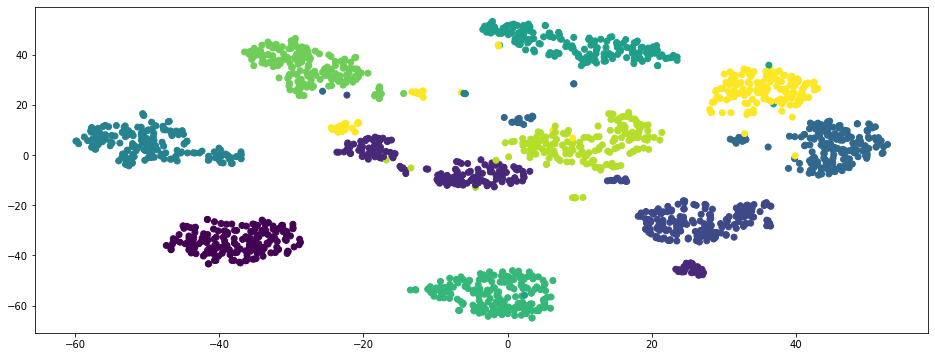

In [55]:
from sklearn.manifold import TSNE

X, y = digits.data, digits.target
X_tsne_transformed = TSNE(n_components=2, random_state=15).fit_transform(X)

plt.figure(figsize=(16, 6))

xdata, ydata = [], []

for i in range(X_tsne_transformed.shape[0]):
    xdata.append(X_tsne_transformed[i][0])
    ydata.append(X_tsne_transformed[i][1])
plt.scatter(x=xdata, y=ydata, c=y);

**(0.5 points)** From the data transformed using the tSNE, perform hierarchical clustering and $K$-means clustering (take the number of clusters equal to 10). Calculate the silhouette and the $V$-score and compare them to corresponding values obtained from the original data.

In [56]:
clustering = AgglomerativeClustering(n_clusters=10).fit(X_tsne_transformed)
kmeans = KMeans(n_clusters=10, random_state=42).fit(X_tsne_transformed)

print('KMeans: ', silhouette_score(X_tsne_transformed, kmeans.labels_))
print('Hierarhical clustering: ', silhouette_score(X_tsne_transformed, clustering.labels_))

KMeans:  0.6364839
Hierarhical clustering:  0.63592714


In [57]:
#Силуэт
clustering = AgglomerativeClustering(n_clusters=10).fit(X)
kmeans = KMeans(n_clusters=10, random_state=42).fit(X)

print('Kmeans: ', silhouette_score(X, kmeans.labels_))
print('Hierarhical clustering: ', silhouette_score(X, clustering.labels_))

Kmeans:  0.18244258012780126
Hierarhical clustering:  0.17849659940596496


**(0.25 points)** Choose the best partition (in terms of silhouette or $V$-score) and visualize the centers of clusters with images. Did you managed to make each digit correspond to one center of the cluster?

## 4. Results and bonus part

Write in free form what conclusions you made after completing this assignment. Answer the following questions:

**(0.5 points)** Which algorithm gives more meaningful results - hierarchical clustering or $K$- means clustering. Does it depend on the algorithm settings or on the quality evaluation method?

В нашем случае можно сказать, что и K_Means, и ерархическая кластеризация справились достаточно хорошо. Результат K-means связан с числом итераций, оценки 𝑉-measure и силуэт тоже дают схожие результаты.

**(0.5 points)** Imagine the situation where after hierarchical clustering, you need to cluster new data in the same way without retraining the model. Suggest a method how you will do it and how you will measure the quality of clustering of new data.

Можно использовать KNN, затем определить число соседей и далее ориентироваться уже на частоту встречаемости того или иного кластера.

**(0.5 points)** Does dimensionality reduction improve clustering results?

Да, так как основная цель данного метода - это оптимизация модели при слишком большом количестве входных переменных. В случае, когда у нас признаков намного больше, чем наблюдений, мы можем переобучить нашу модель, результаты которой приведут к неверным данным и, соответственно, некорректному поведению нашей модели. В случае с кластеризацией, при большом количестве признаков, разбивать наши наблюдения на кластеры будет тяжело и при высокой размерности наша модель будет думать, что все наблюдения находятся на равном расстоянии друг от друга и это будет негативно сказываться на наших результатах. Если же все наши расстояние будут равны друг другу, то и все наблюдения будут находится в балансе друг с другом, что не приведёт формированию каких-либо осмысленных кластеров.

**(0.5 points)** How to evaluate the quality of dimensional reduction? Suggest at least 2 options.

Из самого первого, пришедшего на ум метода - это сравнить долю ошибок до и после уменьшения размерности. 
Либо следующие техники:
1) Feature selection and Feature extraction
2) Principal Component Analysis (PCA)
3) Random Forests

**(Bonus 2 points)** Load the [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist) dataset. You can also do it with `scikit-learn` as explained [here](https://stackoverflow.com/a/60450028). Explore the data and try to cluster it using different approaches. Compare results of these approaches using the silhouette and the $V$-score.

In [58]:
from sklearn.datasets import fetch_openml
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import v_measure_score as VV
raw_data, raw_labels = fetch_openml('mnist_784', version=1, return_X_y=True)

In [59]:
raw_data

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
raw_labels

0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [61]:
n_samples = 10_000
data = raw_data[:n_samples]
labels = raw_labels[:n_samples]

In [62]:
data = data / 255.
labels = labels.astype('int')
images = data.values.reshape(data.shape[0], 28, 28)

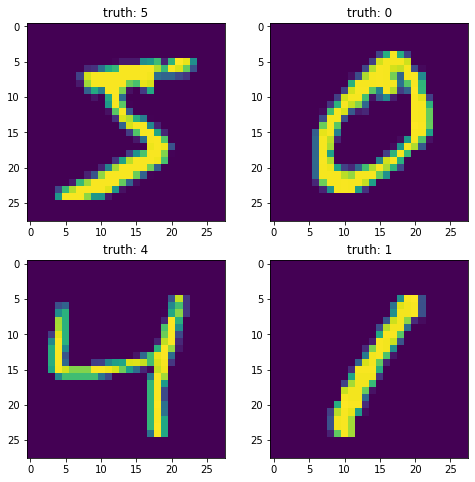

In [63]:
plt.figure(figsize=(8,8))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(images[i])
    plt.title('truth: {}'.format(labels[i]))

In [64]:
#Kmeans
score_VV_1 = []
N = []
for n_clusters in range(2, 21):
    clusterer = KMeans(n_clusters=n_clusters).fit(data)
    preds = clusterer.predict(data)
    centers = clusterer.cluster_centers_

    score = silhouette_score (data, preds, metric='euclidean')
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
    score_VV_1.append(score)
    N.append(n_clusters)

For n_clusters = 2, silhouette score is 0.09083133001699314)
For n_clusters = 3, silhouette score is 0.058426422228165686)
For n_clusters = 4, silhouette score is 0.06328803764922443)
For n_clusters = 5, silhouette score is 0.07204616392915617)
For n_clusters = 6, silhouette score is 0.06945614705236872)
For n_clusters = 7, silhouette score is 0.07530321011406084)
For n_clusters = 8, silhouette score is 0.07801799308933219)
For n_clusters = 9, silhouette score is 0.062169956961830086)
For n_clusters = 10, silhouette score is 0.062157415835137224)
For n_clusters = 11, silhouette score is 0.06298211925241914)
For n_clusters = 12, silhouette score is 0.06290806798330704)
For n_clusters = 13, silhouette score is 0.06465709791678761)
For n_clusters = 14, silhouette score is 0.06815241999879111)
For n_clusters = 15, silhouette score is 0.06733534423145769)
For n_clusters = 16, silhouette score is 0.06862984804631797)
For n_clusters = 17, silhouette score is 0.07177772963891846)
For n_cluster

In [65]:
X_x = score_VV_1

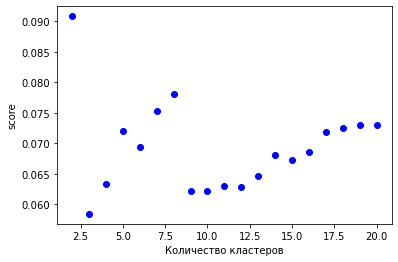

In [66]:
#plot Kmeans
plt.xlabel('Количество кластеров')
plt.ylabel('score')
plt.scatter(x=N, c='b', y=score_VV_1)

In [67]:
#AgglomerativeClustering
score_VV_2 = []
N = []
for n_clusters in range(2, 21):
    preds = AgglomerativeClustering(n_clusters=n_clusters).fit_predict(X)
    centers = clusterer.cluster_centers_

    score = VV(preds, y)
    print ("For n_clusters = {}, VV score is {})".format(n_clusters, score))
    score_VV_2.append(score)
    N.append(n_clusters)

For n_clusters = 2, VV score is 0.40824218623422054)
For n_clusters = 3, VV score is 0.5440613747462535)
For n_clusters = 4, VV score is 0.6211638409365546)
For n_clusters = 5, VV score is 0.709653527412938)
For n_clusters = 6, VV score is 0.7566664944734937)
For n_clusters = 7, VV score is 0.7983006479287973)
For n_clusters = 8, VV score is 0.8457771039270545)
For n_clusters = 9, VV score is 0.8446597933958961)
For n_clusters = 10, VV score is 0.8681701126909083)
For n_clusters = 11, VV score is 0.8553799643497675)
For n_clusters = 12, VV score is 0.86854875186737)
For n_clusters = 13, VV score is 0.8571580830709692)
For n_clusters = 14, VV score is 0.8517473904948195)
For n_clusters = 15, VV score is 0.8401879606185283)
For n_clusters = 16, VV score is 0.8321252325100416)
For n_clusters = 17, VV score is 0.8383091399615094)
For n_clusters = 18, VV score is 0.8271076710894292)
For n_clusters = 19, VV score is 0.826280611466587)
For n_clusters = 20, VV score is 0.8250943463532207)


In [68]:
Y_y = score_VV_2

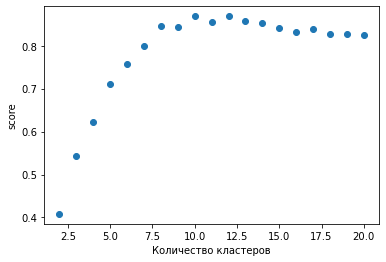

In [69]:
plt.xlabel('Количество кластеров')
plt.ylabel('score')
plt.scatter(x=N, y=score_VV_2)

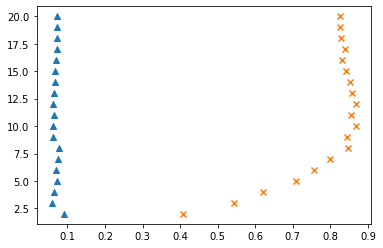

In [70]:
#plot
plt.scatter(X_x, N, marker='^')
plt.scatter(Y_y, N, marker='x')

plt.show()

In [73]:
#SVD
model_svd = TruncatedSVD(10, n_iter=2)
X_svd = model_svd.fit_transform(X)
y_km_svd_pred = clusterer.fit_predict(X_svd)

print(f"Силуэт-score: {silhouette_score(X_svd, y_km_svd_pred)}")

Силуэт-score: 0.2260586563176692
